In [1]:
import io
import os 

# Define the paths you want to add
new_paths = "/gpfslocalsup/pub/anaconda-py3/2023.09/condabin:/gpfslocalsys/cuda/12.2.0/samples:/gpfslocalsys/cuda/12.2.0/nvvm/bin:/gpfslocalsys/cuda/12.2.0/bin:/gpfslocalsup/spack_soft/environment-modules/4.3.1/gcc-4.8.5-ism7cdy4xverxywj27jvjstqwk5oxe2v/bin:/opt/clmgr/sbin:/opt/clmgr/bin:/opt/sgi/sbin:/opt/sgi/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/c3/bin:/usr/lpp/mmfs/bin:/sbin:/bin:/gpfslocalsys/slurm/current/bin:/gpfslocalsup/bin:/gpfslocalsys/bin"

# Get the current PATH
current_path = os.environ.get('PATH', '')

# Add the new paths to the existing PATH
os.environ['PATH'] = new_paths + ':' + current_path

# Verify the change
print(os.environ['PATH'])


import ase
import ase.calculators.calculator as ase_calc
import ase.io as ase_io
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary, ZeroRotation
from ase.md.verlet import VelocityVerlet
import ase.optimize as ase_opt
import matplotlib.pyplot as plt
#import py3Dmol
import e3x
import flax.linen as nn
import jax
import jax.numpy as jnp
from jax import random 
import flax 

import numpy as np 
import functools

/gpfslocalsup/pub/anaconda-py3/2023.09/condabin:/gpfslocalsys/cuda/12.2.0/samples:/gpfslocalsys/cuda/12.2.0/nvvm/bin:/gpfslocalsys/cuda/12.2.0/bin:/gpfslocalsup/spack_soft/environment-modules/4.3.1/gcc-4.8.5-ism7cdy4xverxywj27jvjstqwk5oxe2v/bin:/opt/clmgr/sbin:/opt/clmgr/bin:/opt/sgi/sbin:/opt/sgi/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/c3/bin:/usr/lpp/mmfs/bin:/sbin:/bin:/gpfslocalsys/slurm/current/bin:/gpfslocalsup/bin:/gpfslocalsys/bin:/gpfslocalsup/pub/anaconda-py3/2023.09/envs/python-3.11.5/bin:/gpfslocalsup/pub/jupyter/production/jupyterhub/bin:/gpfslocalsup/pub/jupyter/production/jupyterhub/bin:/gpfslocalsup/spack_soft/environment-modules/4.3.1/gcc-4.8.5-ism7cdy4xverxywj27jvjstqwk5oxe2v/bin:/opt/clmgr/sbin:/opt/clmgr/bin:/opt/sgi/sbin:/opt/sgi/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin:/opt/c3/bin:/usr/lpp/mmfs/bin:/sbin:/bin:/gpfslocalsys/slurm/current/bin:/gpfslocalsup/bin:/gpfslocalsys/bin


In [2]:
class MessagePassingModel(nn.Module):
  features: int = 32
  max_degree: int = 2
  num_iterations: int = 3
  num_basis_functions: int = 8
  cutoff: float = 5.0
  max_atomic_number: int = 118  # This is overkill for most applications.


  def energy(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size):
    # 1. Calculate displacement vectors.
    positions_dst = e3x.ops.gather_dst(positions, dst_idx=dst_idx)
    positions_src = e3x.ops.gather_src(positions, src_idx=src_idx)
    displacements = positions_src - positions_dst  # Shape (num_pairs, 3).

    # 2. Expand displacement vectors in basis functions.
    basis = e3x.nn.basis(  # Shape (num_pairs, 1, (max_degree+1)**2, num_basis_functions).
      displacements,
      num=self.num_basis_functions,
      max_degree=self.max_degree,
      radial_fn=e3x.nn.reciprocal_bernstein,
      cutoff_fn=functools.partial(e3x.nn.smooth_cutoff, cutoff=self.cutoff)
    )

    # 3. Embed atomic numbers in feature space, x has shape (num_atoms, 1, 1, features).
    x = e3x.nn.Embed(num_embeddings=self.max_atomic_number+1, features=self.features)(atomic_numbers)

    # 4. Perform iterations (message-passing + atom-wise refinement).
    for i in range(self.num_iterations):
      # Message-pass.
      if i == self.num_iterations-1:  # Final iteration.
        # Since we will only use scalar features after the final message-pass, we do not want to produce non-scalar
        # features for efficiency reasons.
        y = e3x.nn.MessagePass(max_degree=0, include_pseudotensors=False)(x, basis, dst_idx=dst_idx, src_idx=src_idx)
        # After the final message pass, we can safely throw away all non-scalar features.
        x = e3x.nn.change_max_degree_or_type(x, max_degree=0, include_pseudotensors=False)
      else:
        # In intermediate iterations, the message-pass should consider all possible coupling paths.
        y = e3x.nn.MessagePass()(x, basis, dst_idx=dst_idx, src_idx=src_idx)
      y = e3x.nn.add(x, y)

      # Atom-wise refinement MLP.
      y = e3x.nn.Dense(self.features)(y)
      y = e3x.nn.silu(y)
      y = e3x.nn.Dense(self.features, kernel_init=jax.nn.initializers.zeros)(y)

      # Residual connection.
      x = e3x.nn.add(x, y)

    # 5. Predict atomic energies with an ordinary dense layer.
    element_bias = self.param('element_bias', lambda rng, shape: jnp.zeros(shape), (self.max_atomic_number+1))
    atomic_energies = nn.Dense(1, use_bias=False, kernel_init=jax.nn.initializers.zeros)(x)  # (..., Natoms, 1, 1, 1)
    atomic_energies = jnp.squeeze(atomic_energies, axis=(-1, -2, -3))  # Squeeze last 3 dimensions.
    #atomic_energies += element_bias[atomic_numbers]
    atomic_energies += jax.numpy.take(element_bias, atomic_numbers, axis=0)

    # 6. Sum atomic energies to obtain the total energy.
    energy = jax.ops.segment_sum(atomic_energies, segment_ids=batch_segments, num_segments=batch_size)

    # To be able to efficiently compute forces, our model should return a single output (instead of one for each
    # molecule in the batch). Fortunately, since all atomic contributions only influence the energy in their own
    # batch segment, we can simply sum the energy of all molecules in the batch to obtain a single proxy output
    # to differentiate.
    return -jnp.sum(energy), energy  # Forces are the negative gradient, hence the minus sign.


  @nn.compact
  def __call__(self, atomic_numbers, positions, dst_idx, src_idx, batch_segments=None, batch_size=None):
    if batch_segments is None:
      batch_segments = jnp.zeros_like(atomic_numbers)
      batch_size = 1

    # Since we want to also predict forces, i.e. the gradient of the energy w.r.t. positions (argument 1), we use
    # jax.value_and_grad to create a function for predicting both energy and forces for us.
    energy_and_forces = jax.value_and_grad(self.energy, argnums=1, has_aux=True)
    (_, energy), forces = energy_and_forces(atomic_numbers, positions, dst_idx, src_idx, batch_segments, batch_size)

    return energy, forces


@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return message_passing_model.apply(params,
    atomic_numbers=atomic_numbers,
    positions=positions,
    dst_idx=dst_idx,
    src_idx=src_idx,
  )


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )
    self.results['energy'] = energy * ase.units.kcal/ase.units.mol
    self.results['forces'] = forces * ase.units.kcal/ase.units.mol
    
    
@functools.partial(jax.jit, static_argnames=('model_apply', 'optimizer_update', 'batch_size'))
def train_step(model_apply, optimizer_update, batch, batch_size, forces_weight, opt_state, params):
  def loss_fn(params):
    energy, forces = model_apply(
      params,
      atomic_numbers=batch['atomic_numbers'],
      positions=batch['positions'],
      dst_idx=batch['dst_idx'],
      src_idx=batch['src_idx'],
      batch_segments=batch['batch_segments'],
      batch_size=batch_size
    )
    loss = mean_squared_loss(
      energy_prediction=energy,
      energy_target=batch['energy'],
      forces_prediction=forces,
      forces_target=batch['forces'],
      forces_weight=forces_weight
    )
    return loss, (energy, forces)
  (loss, (energy, forces)), grad = jax.value_and_grad(loss_fn, has_aux=True)(params)
  updates, opt_state = optimizer_update(grad, opt_state, params)
  params = optax.apply_updates(params, updates)
  energy_mae = mean_absolute_error(energy, batch['energy'])
  forces_mae = mean_absolute_error(forces, batch['forces'])
  return params, opt_state, loss, energy_mae, forces_mae


@functools.partial(jax.jit, static_argnames=('model_apply', 'batch_size'))
def eval_step(model_apply, batch, batch_size, forces_weight, params):
  energy, forces = model_apply(
    params,
    atomic_numbers=batch['atomic_numbers'],
    positions=batch['positions'],
    dst_idx=batch['dst_idx'],
    src_idx=batch['src_idx'],
    batch_segments=batch['batch_segments'],
    batch_size=batch_size
  )
  loss = mean_squared_loss(
    energy_prediction=energy,
    energy_target=batch['energy'],
    forces_prediction=forces,
    forces_target=batch['forces'],
    forces_weight=forces_weight
  )
  energy_mae = mean_absolute_error(energy, batch['energy'])
  forces_mae = mean_absolute_error(forces, batch['forces'])
  return loss, energy_mae, forces_mae
    

In [3]:

os.system('pwd')
os.system('ls -ltr')
# Model hyperparameters.
features = 32
max_degree = 1
num_iterations = 3
num_basis_functions = 16
cutoff = 5.0
# Training hyperparameters.
num_train = 900
num_valid = 100

#Load the data: 
# Download the dataset.
filename = "md17_ethanol.npz"
if not os.path.exists(filename):
  print(f"Downloading {filename} (this may take a while)...")
  urllib.request.urlretrieve(f"http://www.quantum-machine.org/gdml/data/npz/{filename}", filename)
  
def prepare_datasets(key, num_train, num_valid):
  # Load the dataset.
  dataset = np.load(filename)

  # Make sure that the dataset contains enough entries.
  num_data = len(dataset['E'])
  num_draw = num_train + num_valid
  if num_draw > num_data:
    raise RuntimeError(
      f'datasets only contains {num_data} points, requested num_train={num_train}, num_valid={num_valid}')

  # Randomly draw train and validation sets from dataset.
  choice = np.asarray(jax.random.choice(key, num_data, shape=(num_draw,), replace=False))
  train_choice = choice[:num_train]
  valid_choice = choice[num_train:]

  # Determine mean energy of the training set.
  mean_energy = np.mean(dataset['E'][train_choice])  # ~ -97000

  # Collect and return train and validation sets.
  train_data = dict(
    energy=jnp.asarray(dataset['E'][train_choice, 0] - mean_energy),
    forces=jnp.asarray(dataset['F'][train_choice]),
    atomic_numbers=jnp.asarray(dataset['z']),
    positions=jnp.asarray(dataset['R'][train_choice]),
  )
  valid_data = dict(
    energy=jnp.asarray(dataset['E'][valid_choice, 0] - mean_energy),
    forces=jnp.asarray(dataset['F'][valid_choice]),
    atomic_numbers=jnp.asarray(dataset['z']),
    positions=jnp.asarray(dataset['R'][valid_choice]),
  )
  return train_data, valid_data, mean_energy

# Create PRNGKeys.
key = jax.random.PRNGKey(0)
data_key, train_key = jax.random.split(key, 2)

# Draw training and validation sets.
train_data, valid_data, _ = prepare_datasets(data_key, num_train=num_train, num_valid=num_valid)
  

In [4]:

# Re-initialize the model exactly as you did before training
message_passing_model = MessagePassingModel(
    features=features,
    max_degree=max_degree,
    num_iterations=num_iterations,
    num_basis_functions=num_basis_functions,
    cutoff=cutoff,
)

# Create a PRNGKey for initialization
key = random.PRNGKey(0)  # Use a key, the specific value is not crucial here

# You don't need to provide dummy data for model structure initialization
# Instead, you only need to specify the PRNGKey
# This step is assuming the model's init doesn't explicitly require the input shapes at this stage
#dummy_params = reinitialized_model.init(key)
dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(train_data['atomic_numbers']))
atomic_numbers=train_data['atomic_numbers']
positions=train_data['positions'][0]
dummy_params = message_passing_model.init(key, atomic_numbers=atomic_numbers, positions=positions, dst_idx=dst_idx, src_idx=src_idx)
with open('model_params.bin', 'rb') as f:
    serialized_params = f.read()

params = flax.serialization.from_bytes(dummy_params, serialized_params)    

In [5]:

@jax.jit
def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
  return message_passing_model.apply(params,
    atomic_numbers=jax.numpy.array(atomic_numbers),
    positions= jax.numpy.array(positions),
    dst_idx=jax.numpy.array(dst_idx),
    src_idx=jax.numpy.array(src_idx),
  )

### def evaluate_energies_and_forces(atomic_numbers, positions, dst_idx, src_idx):
###     # Convert inputs to JAX arrays if they aren't already
###     atomic_numbers_jax = jax.numpy.array(atomic_numbers)
###     positions_jax = jax.numpy.array(positions)
###     dst_idx_jax = jax.numpy.array(dst_idx)
###     src_idx_jax = jax.numpy.array(src_idx)
### 
###     # JIT-compiled inner function
###     @jax.jit
###     def compute(atomic_numbers, positions, dst_idx, src_idx):
###         return message_passing_model.apply(params,
###             atomic_numbers=atomic_numbers,
###             positions=positions,
###             dst_idx=dst_idx,
###             src_idx=src_idx,
###         )
### 
###     # Call the JIT-compiled function
###     energy, forces = compute(atomic_numbers_jax, positions_jax, dst_idx_jax, src_idx_jax)
### 
###     # Ensure explicit conversion from JAX arrays to NumPy arrays
###     #return energy.block_until_ready().to_numpy(), forces.block_until_ready().to_numpy()
###     #return energy.block_until_ready().numpy(), forces.block_until_ready().numpy()
###     return jax.device_get(energy.block_until_ready()), jax.device_get(forces.block_until_ready())
 


class MessagePassingCalculator(ase_calc.Calculator):
  implemented_properties = ["energy", "forces"]

  def calculate(self, atoms, properties, system_changes = ase.calculators.calculator.all_changes):
    ase_calc.Calculator.calculate(self, atoms, properties, system_changes)
    dst_idx, src_idx = e3x.ops.sparse_pairwise_indices(len(atoms))
    energy, forces = evaluate_energies_and_forces(
      atomic_numbers=atoms.get_atomic_numbers(),
      positions=atoms.get_positions(),
      dst_idx=dst_idx,
      src_idx=src_idx
    )
    # Assuming energy and forces are initially JAX arrays and forces is correctly shaped as [num_atoms, 3]
    #energy_np = np.array(energy.block_until_ready()).item()  # Convert to Python scalar
    #forces_np = np.array(forces.block_until_ready())  # Ensure this is a 2D NumPy array, [num_atoms, 3]

    

    # Correctly checking if an object is a JAX array
    if isinstance(energy, jnp.ndarray):
        energy_np = np.array(jax.device_get(energy)).item()  # Convert to Python scalar
    else:
        energy_np = np.array(energy).item()
    
    if isinstance(forces, jnp.ndarray):
        forces_np = np.array(jax.device_get(forces))  # Ensure this is a 2D NumPy array, [num_atoms, 3]
    else:
        forces_np = np.array(forces)

    


    
    self.results['energy'] = energy_np * ase.units.kcal/ase.units.mol
    self.results['forces'] = forces_np * ase.units.kcal/ase.units.mol

# Initialize atoms object and attach calculator.
atoms = ase.Atoms(train_data['atomic_numbers'], train_data['positions'][0])
atoms.set_calculator(MessagePassingCalculator())

# Run structure optimization with BFGS.
_ = ase_opt.BFGS(atoms).run(fmax=0.05)

      Step     Time          Energy         fmax
BFGS:    0 20:17:26        0.066053        2.7992
BFGS:    1 20:17:26       -0.210720        1.6866
BFGS:    2 20:17:26       -0.350615        1.4339
BFGS:    3 20:17:26       -0.408371        0.9193
BFGS:    4 20:17:26       -0.444367        0.4461
BFGS:    5 20:17:26       -0.458139        0.3737
BFGS:    6 20:17:26       -0.483333        0.3686
BFGS:    7 20:17:26       -0.491301        0.2662
BFGS:    8 20:17:26       -0.497547        0.2413
BFGS:    9 20:17:26       -0.502520        0.2461
BFGS:   10 20:17:26       -0.507064        0.2226
BFGS:   11 20:17:26       -0.509868        0.1492
BFGS:   12 20:17:26       -0.511501        0.1185
BFGS:   13 20:17:26       -0.512699        0.1044
BFGS:   14 20:17:26       -0.513665        0.0819
BFGS:   15 20:17:26       -0.514220        0.0688
BFGS:   16 20:17:26       -0.514611        0.0737
BFGS:   17 20:17:26       -0.515138        0.0948
BFGS:   18 20:17:26       -0.516016        0.1117
B

In [6]:
#vizu# # Write structure to xyz file.
#vizu# xyz = io.StringIO()
#vizu# ase_io.write(xyz, atoms, format='xyz')
#vizu# 
#vizu# # Visualize the structure with py3Dmol.
#vizu# view = py3Dmol.view()
#vizu# view.addModel(xyz.getvalue(), 'xyz')
#vizu# view.setStyle({'stick': {'radius': 0.15}, 'sphere': {'scale': 0.25}})
#vizu# view.show()

In [7]:
# Parameters.
temperature = 1000
timestep_fs = 1.0
num_steps = 40000

# Draw initial momenta.
MaxwellBoltzmannDistribution(atoms, temperature_K=temperature)
Stationary(atoms)  # Remove center of mass translation.
ZeroRotation(atoms)  # Remove rotations.

# Initialize Velocity Verlet integrator.
integrator = VelocityVerlet(atoms, timestep=timestep_fs*ase.units.fs)

# Run molecular dynamics.
frames = np.zeros((num_steps, len(atoms), 3))
potential_energy = np.zeros((num_steps,))
kinetic_energy = np.zeros((num_steps,))
total_energy = np.zeros((num_steps,))
for i in range(num_steps):
  # Run 1 time step.
  integrator.run(1)
  # Save current frame and keep track of energies.
  frames[i] = atoms.get_positions()
  potential_energy[i] = atoms.get_potential_energy()
  kinetic_energy[i] = atoms.get_kinetic_energy()
  total_energy[i] = atoms.get_total_energy()
  # Occasionally print progress.
  if i % 1000 == 0:
    print(f"step {i:5d} epot {potential_energy[i]: 5.3f} ekin {kinetic_energy[i]: 5.3f} etot {total_energy[i]: 5.3f}")


step     0 epot -0.320 ekin  1.416 etot  1.096
step  1000 epot  0.225 ekin  0.883 etot  1.108
step  2000 epot  0.515 ekin  0.603 etot  1.118
step  3000 epot  0.025 ekin  1.077 etot  1.102
step  4000 epot  0.545 ekin  0.583 etot  1.127
step  5000 epot  0.486 ekin  0.646 etot  1.132
step  6000 epot  0.468 ekin  0.664 etot  1.132
step  7000 epot  0.209 ekin  0.911 etot  1.120
step  8000 epot  0.134 ekin  0.987 etot  1.121
step  9000 epot  0.360 ekin  0.768 etot  1.128
step 10000 epot  0.164 ekin  0.954 etot  1.118
step 11000 epot  0.624 ekin  0.526 etot  1.150
step 12000 epot  0.592 ekin  0.554 etot  1.146
step 13000 epot  0.710 ekin  0.430 etot  1.139
step 14000 epot  0.454 ekin  0.682 etot  1.136
step 15000 epot  0.426 ekin  0.716 etot  1.142
step 16000 epot  0.057 ekin  1.076 etot  1.134
step 17000 epot  0.246 ekin  0.896 etot  1.142
step 18000 epot  0.277 ekin  0.850 etot  1.127
step 19000 epot  0.380 ekin  0.757 etot  1.138
step 20000 epot  0.101 ekin  1.036 etot  1.137
step 21000 ep

In [8]:
#vizu# view.getModel().setCoordinates(frames, 'array')
#vizu# view.animate({'loop': 'forward', 'interval': 0.1})
#vizu# view.show()

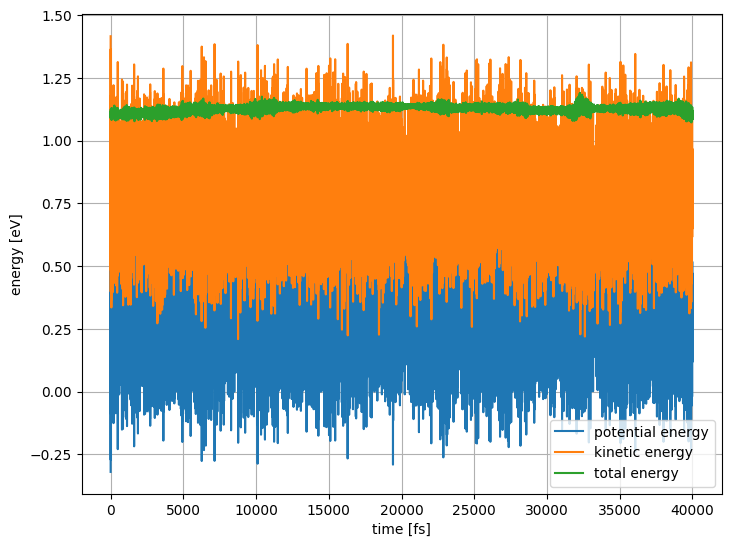

In [10]:
%matplotlib inline
plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
plt.xlabel('time [fs]')
plt.ylabel('energy [eV]')
time = np.arange(num_steps) * timestep_fs
plt.plot(time, potential_energy, label='potential energy')
plt.plot(time, kinetic_energy, label='kinetic energy')
plt.plot(time, total_energy, label='total energy')
plt.legend()
plt.grid()